# Predictive Financial Modeling
## LSTM

`-- Leo Lonzarich, 12 January 2022 // [Updated 6-3-23] --`


### Table of Contents
- [Importing Stock Data](#import)
    - [Beta Calculation](#beta)
- [LSTM Model](#lstmmodel)
    - [Preprocessing](#preprocessing)
    - [Building](#build)
    - [Training](#train)
    - [Predictions](#preds)



### General Comments

- Using Long Short Term Memory (LSTM), an artificial recurrent neural network, to predict closing future stock closing performance.
    - LSTM works best when handeling large-scale datasets like these.
<br><br>
- Selecting past 60 to make next-day predictions.
- Credit to ML tutorial of @`Computer Science` on YT.

<br><br>

---
#### TODO

- I'm only using univariate stacked LSTM here. Try Bidirectional LSTM to see if it adds any explanatory power. (https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)

- Make statistical analysis program to evaluate model efficacy and efficiency (comp time vs. accuracy).


In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, LSTM

from pandas_datareader import data as pdr
import yfinance as yfin
import datetime as dt

# Yahoo API may have broken previous versions of pd_datareader, so this is a workaround.
yfin.pdr_override()
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def datImport(ticker, start, end=dt.datetime.today(), verbose=False):
    # importing daily equity or market data.
    data = pdr.get_data_yahoo(ticker, start, end).rename(columns= {'Adj Close': 'AdjClose'})

    if verbose:
        print(data.shape[0], "days loaded with attributes: \n", data.keys())

        fig, ax = plt.subplots(1,1, dpi=300, figsize=(16,8),
            constrained_layout=False)

        ax.plot(data.index, data.AdjClose)

        ax.set_title('Adjusted Closing Prices for %s (USD), %s-%s' 
                    %(ticker, start.year, end.year))
        ax.set_xlabel('Date', fontsize=18)
        ax.set_ylabel('Adjusted Closing Price (USD)', fontsize=18)

        # Set major and minor date tick locators
        maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,6))
        ax.xaxis.set_major_locator(maj_loc)
        min_loc = mdates.MonthLocator()
        ax.xaxis.set_minor_locator(min_loc)

        # Set major date tick formatter
        zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
        maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                            show_offset=False)
        ax.xaxis.set_major_formatter(maj_fmt)

        ax.figure.autofmt_xdate(rotation=0, ha='center')
        ax.set_xlim(data.index.min(), data.index.max());

    return data


def beta(df, market=None):
    # Calculating betas using prices from every business day)
    # If the market values are not passed,
    # I'll assume they are located in a column
    # named 'Market'.  If not, this will fail.
    if market is None:
        market = df['MarketClose']
        df = df.drop('MarketClose', axis=1)
    X = market.values.reshape(-1, 1)
    X = np.concatenate([np.ones_like(X), X], axis=1)
    b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(df.values)
    
    return float(b[1])


def roll(df, window=252):
    # Takes 'w'-sized slices from dataframe, incrementing 1 entry at a time.
    for i in range(df.shape[0] - w + 1):
        yield pd.DataFrame(df.values[i:i+window, :], df.index[i:i+window],
                           df.columns)
        

def addBeta(stock, market, window=252, verbose=False):
    # Calc beta across given df of closing prices.
    # Window default is stet to calculate yearly beta.
    betas = np.array([])
    data = pd.concat([stock.AdjClose, market.MarketClose], axis=1)

    for  i, sdf in enumerate(roll(data.pct_change().dropna(), window )):
        betas = np.append(betas, beta(sdf))

    full_data = data.drop(index=data.index[:window], axis=0, inplace=False)
    full_data['Beta'] = betas.tolist()

    return full_data

In [11]:
google = datImport('GOOG', dt.datetime(2012,1,1))
spy = datImport('SPY', dt.datetime(2012,1,1))
spy.rename(columns={'AdjClose': 'MarketClose'})

# addBeta(google, spy)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,MarketClose,Volume
Date,,,,,,
2012-01-03,127.760002,128.380005,127.430000,127.500000,103.596184,193697900
2012-01-04,127.199997,127.809998,126.709999,127.699997,103.758705,127186500
2012-01-05,127.010002,128.229996,126.430000,128.039993,104.034943,173895000
2012-01-06,128.199997,128.220001,127.290001,127.709999,103.766823,148050000
2012-01-09,128.000000,128.179993,127.410004,128.020004,104.018692,99530200
...,...,...,...,...,...,...
2023-03-06,405.049988,407.450012,404.010010,404.470001,404.470001,72795900
2023-03-07,404.420013,404.670013,397.630005,398.269989,398.269989,108310600
2023-03-08,398.390015,399.709991,396.589996,398.920013,398.920013,74746600


## Importing Data:<a class="anchor" id="import"></a>
---

In [12]:
# Yahoo Finance stock scraping.
# **Careful with how many times you run this to avoid IP ban**
tickr = 'AAPL'
start = dt.datetime(2012, 1, 1)
end = dt.datetime.today()

stock = pdr.get_data_yahoo(tickr, start, end).rename(columns= {'Adj Close': 'AdjClose'})

print(stock.shape[0], "unique points loaded with attributes: \n", stock.
      keys())

[*********************100%***********************]  1 of 1 completed
2815 unique points loaded with attributes: 
 Index(['Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume'], dtype='object')


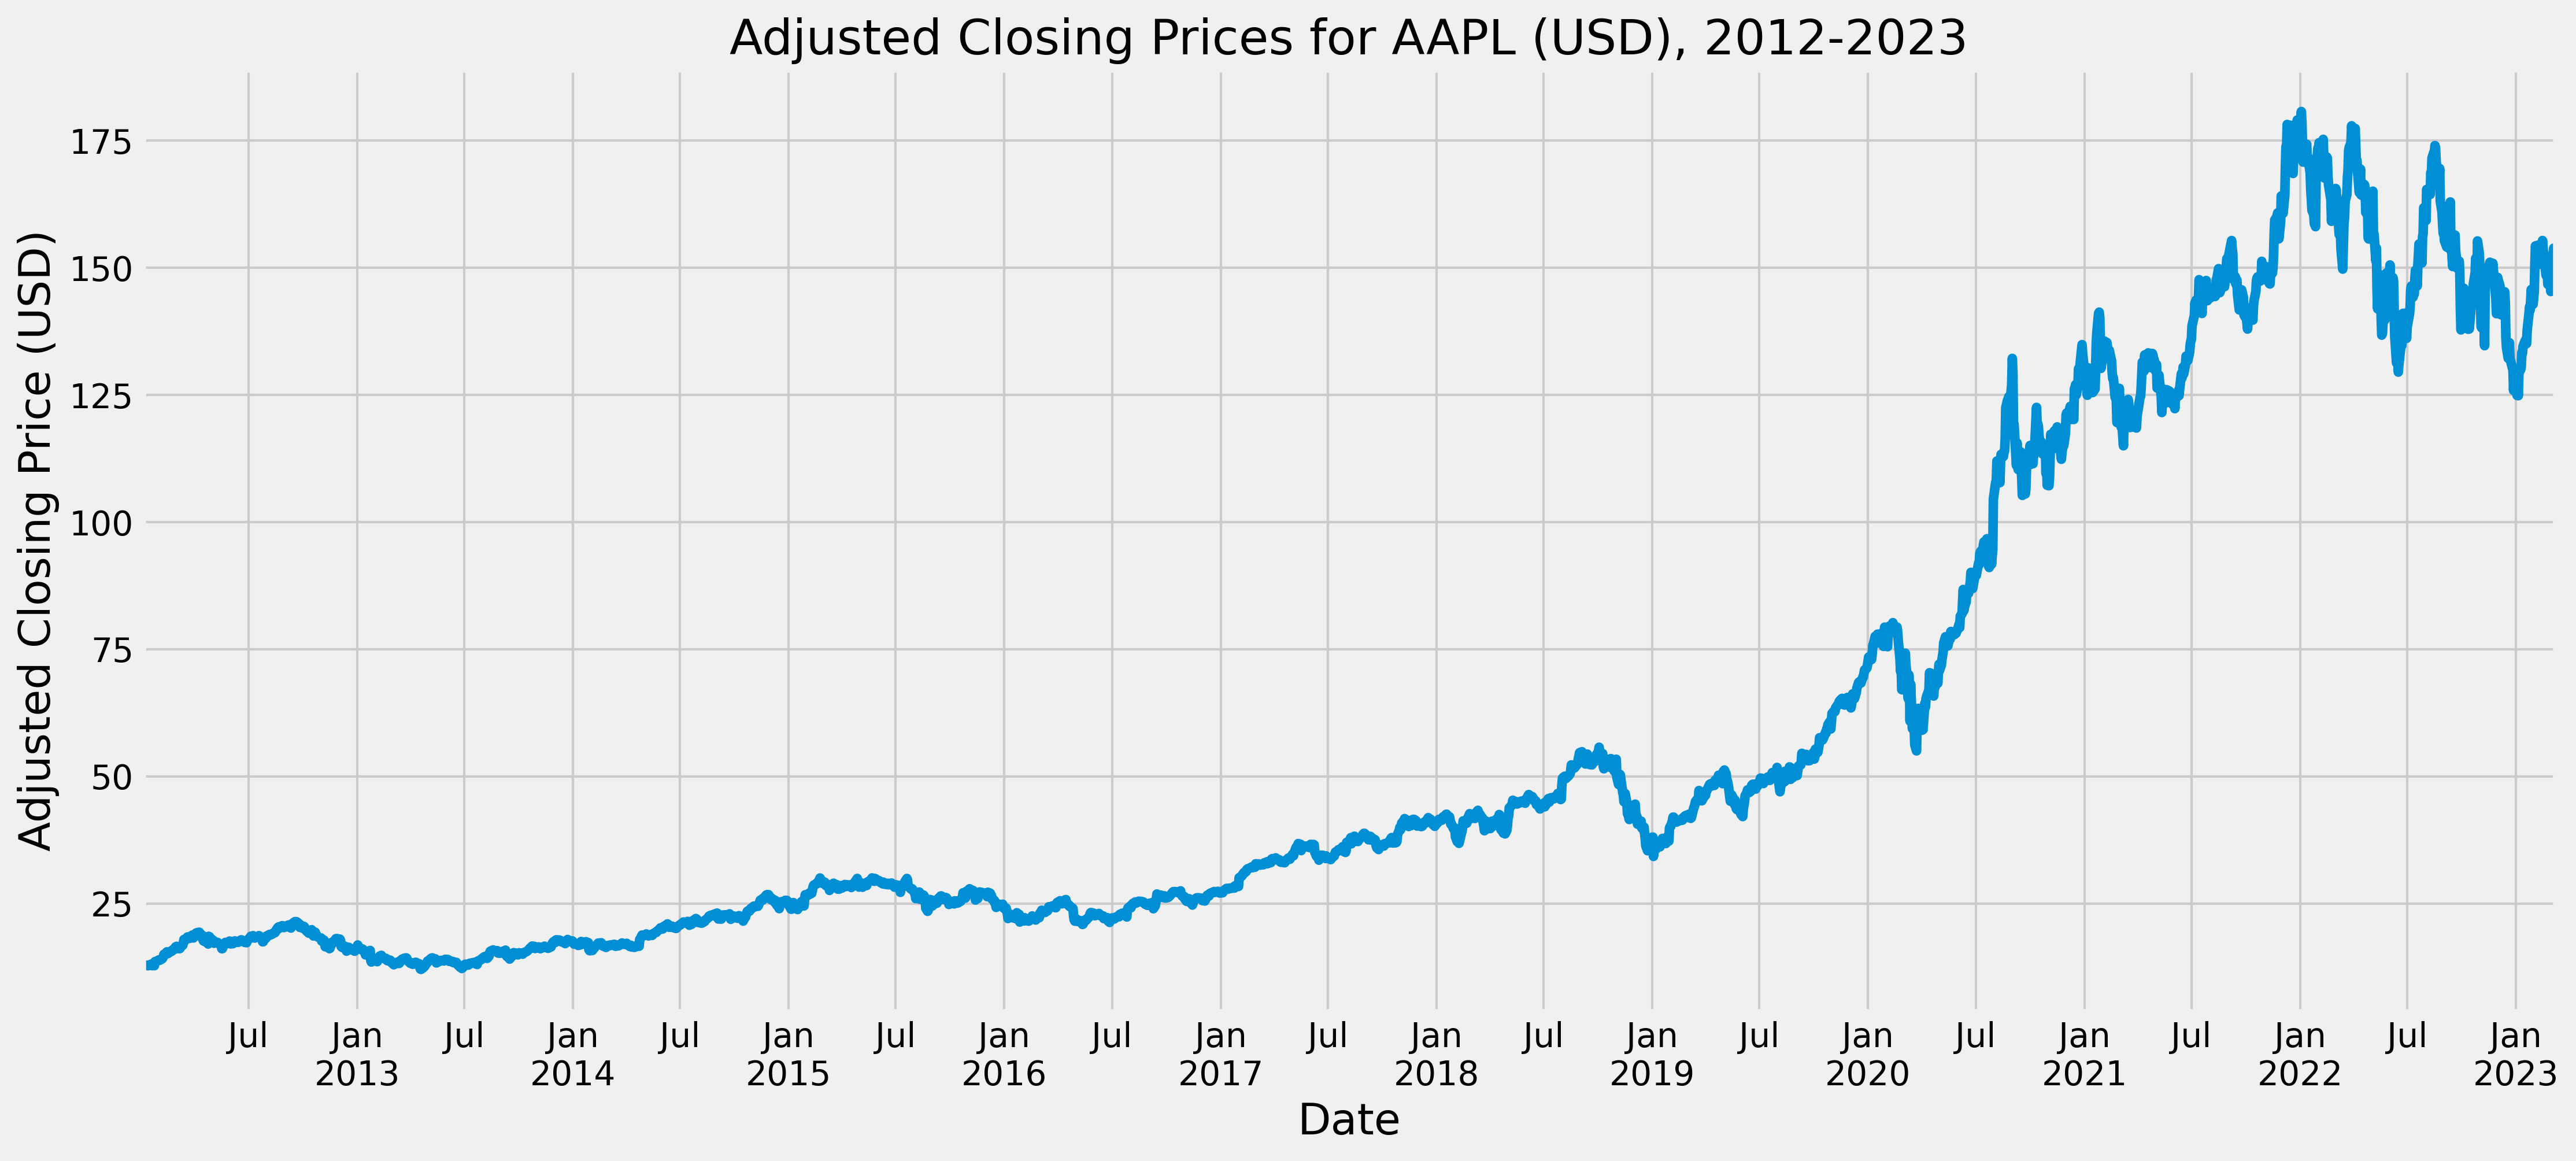

In [13]:
# Plotting opening prices.

fig, ax = plt.subplots(1,1, dpi=300, figsize=(16,8),
    constrained_layout=False)

ax.plot(stock.index, stock.AdjClose)

ax.set_title('Adjusted Closing Prices for %s (USD), %s-%s' 
             %(tickr, start.year, end.year))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Adjusted Closing Price (USD)', fontsize=18)

# Set major and minor date tick locators
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,6))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                      show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

ax.figure.autofmt_xdate(rotation=0, ha='center')
ax.set_xlim(stock.index.min(), stock.index.max());

### Beta Calculation:<a class="anchor" id="beta"></a>

Using linalg package with roll generator for improved efficiency.

In [14]:
# Obtaining other features: possibilities include CAPE, PE, beta.

# Specify beta (252 = 1yr)
window = 252
market_tickr = 'SPY'

def beta(df, market=None):
    # If the market values are not passed,
    # I'll assume they are located in a column
    # named 'Market'.  If not, this will fail.
    if market is None:
        market = df['MarketClose']
        df = df.drop('MarketClose', axis=1)
    X = market.values.reshape(-1, 1)
    X = np.concatenate([np.ones_like(X), X], axis=1)
    b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(df.values)
    return float(b[1])

def roll(df, w=252):
    # Takes 'w'-sized slices from dataframe, incrementing 1 entry at a time.
    for i in range(df.shape[0] - w + 1):
        yield pd.DataFrame(df.values[i:i+w, :], df.index[i:i+w],
                           df.columns)


#### Combining stock + market data and computing.
market = pdr.get_data_yahoo(market_tickr,
                            start,
                            end).rename(columns={'Adj Close': 'MarketClose'})

betas = np.array([])
dat = pd.concat([stock.AdjClose, market.MarketClose], axis=1)

for  i, sdf in enumerate(roll(dat.pct_change().dropna(), window)):
    betas = np.append(betas, beta(sdf))

datFull = dat.drop(index=dat.index[:window], axis=0, inplace=False)
datFull['Beta'] = betas.tolist()

[*********************100%***********************]  1 of 1 completed


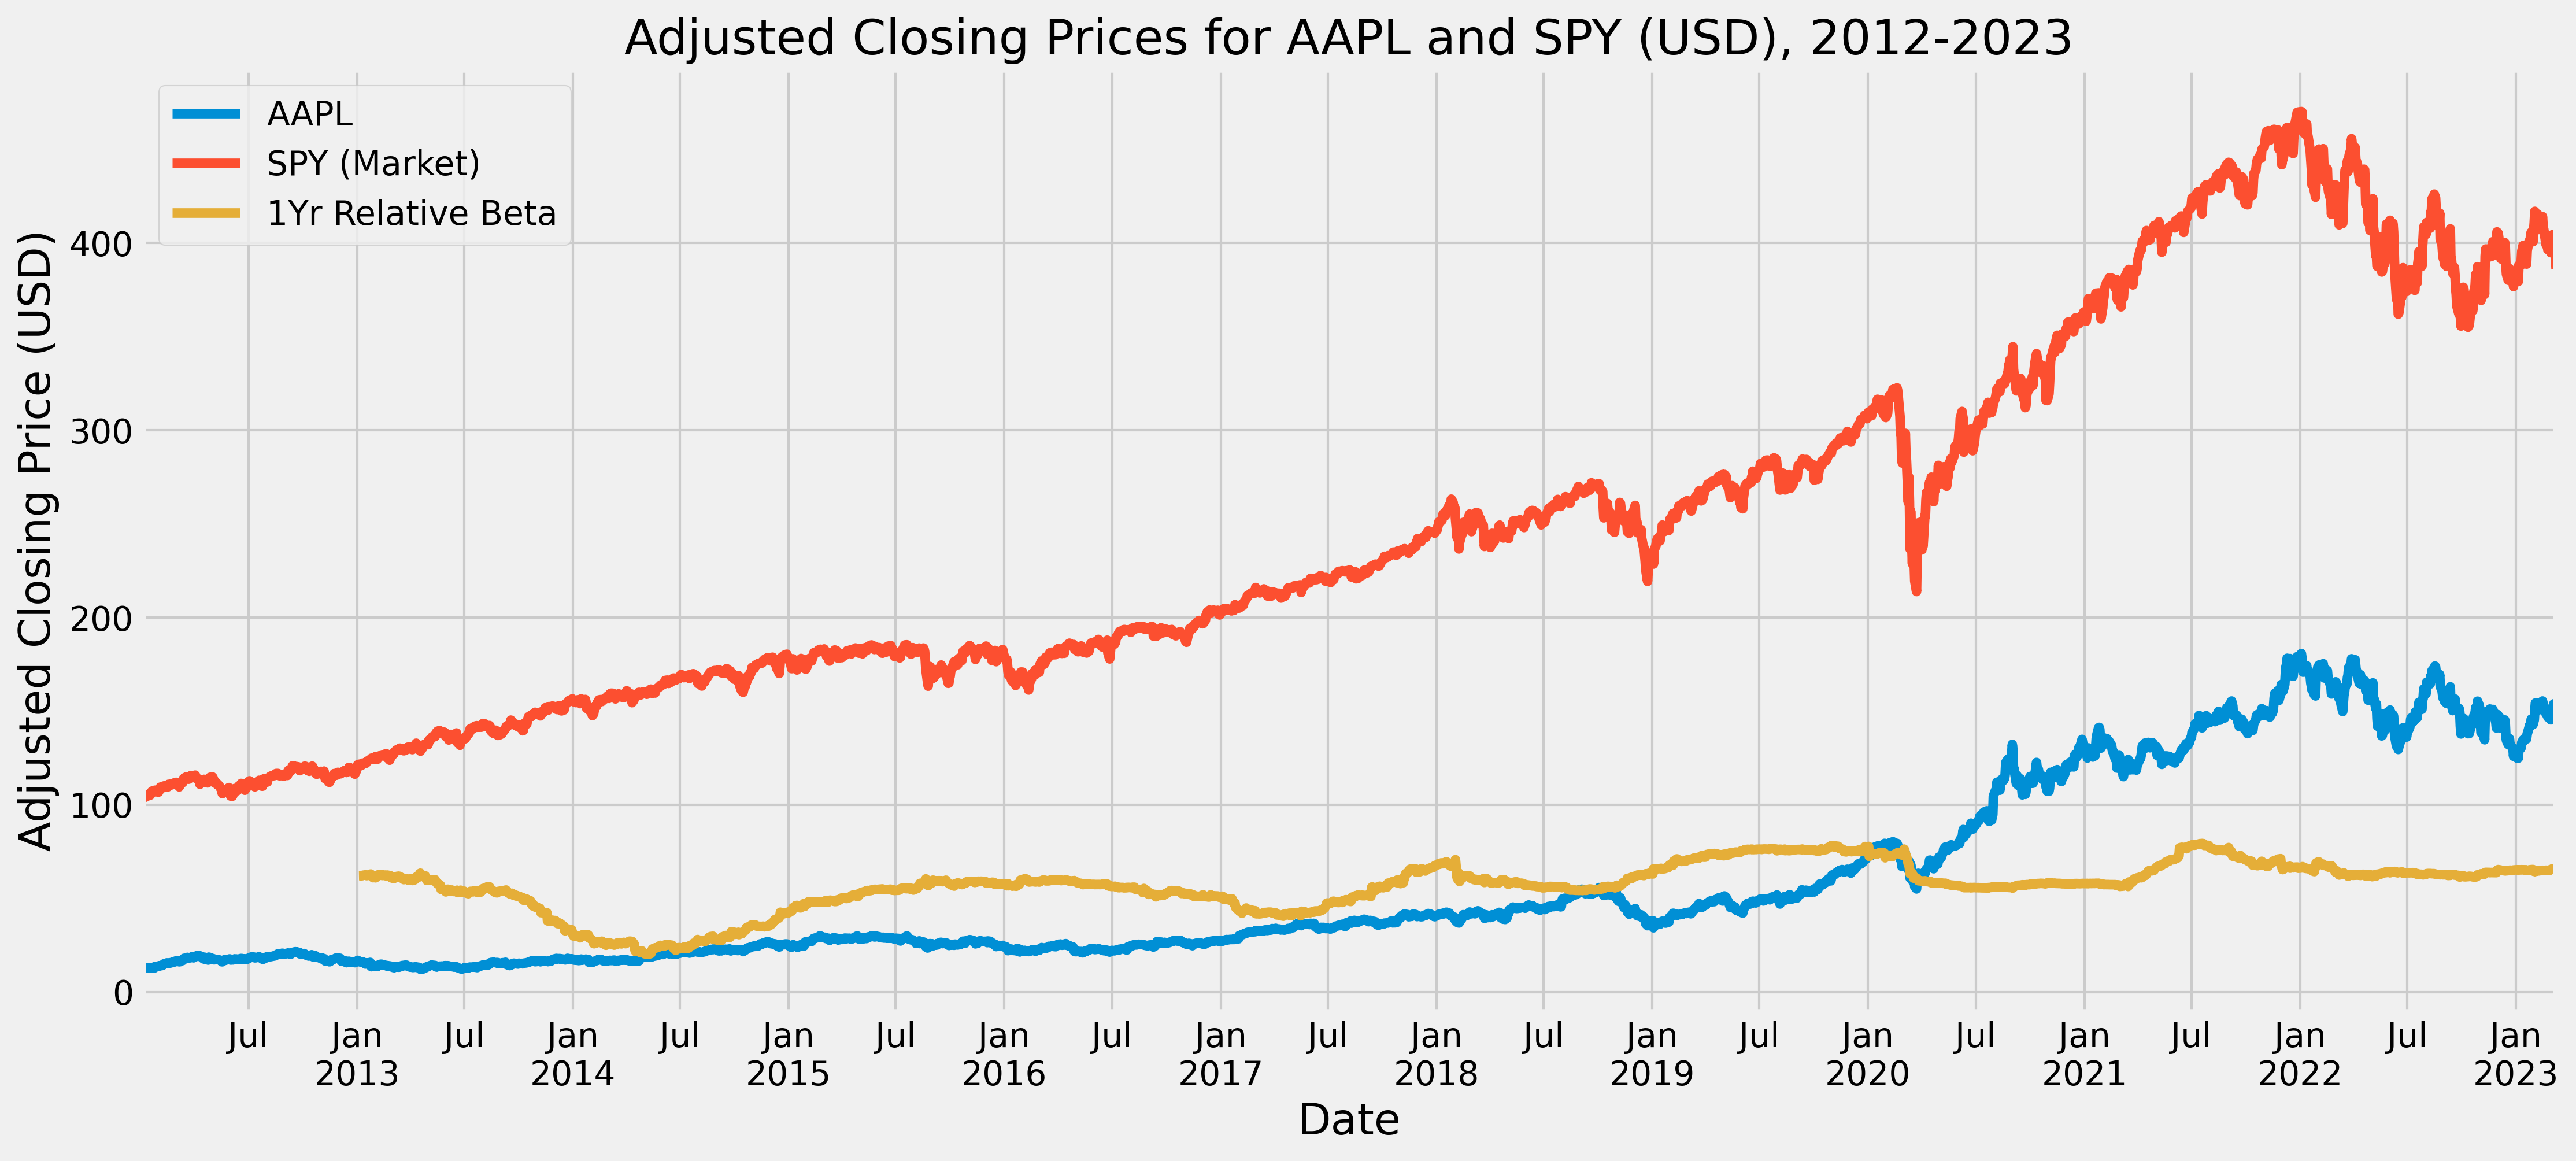

In [15]:
# Plotting opening prices.

fig, ax = plt.subplots(1,1, dpi=300, figsize=(16,8),
    constrained_layout=False)

ax.plot(stock.index, stock.AdjClose, label=tickr)
ax.plot(market.index, market.MarketClose, label=market_tickr + ' (Market)')
ax.plot(datFull.index, datFull.Beta*50, linestyle='-', label='1Yr Relative Beta')


ax.set_title('Adjusted Closing Prices for %s and %s (USD), %s-%s' 
             %(tickr, market_tickr, start.year, end.year))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Adjusted Closing Price (USD)', fontsize=18)
ax.legend()

# Set major and minor date tick locators
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,6))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                      show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

ax.figure.autofmt_xdate(rotation=0, ha='center')
ax.set_xlim(stock.index.min(), stock.index.max());

## LSTM Model<a class="anchor" id="lstmmodel"></a>
---

### Preprocessing:<a class="anchor" id="preprocessing"></a>

In [16]:
# consolidating 'Close' prices to one stock.

close = datFull.filter(['AdjClose']).values
len_training = math.ceil(len(close) * 0.8)

# scaling data. Ensures quicker convergence to solution.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler.fit_transform(close)

# scaled training data.
train_close = scaled_close[0:len_training,:]

x_train = [] # features
y_train = [] # desired prediction

for i in range(60, len(train_close)):
    x_train.append(train_close[i-60:i,0])
    y_train.append(train_close[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# reshaping to obtain 3D reps for x_train (which is currently 2d) to pass into LSTM.
# LSTM expects d1 # of samples, d2 # of timesteps, and d3 # of features.

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Building:<a class="anchor" id="build"></a>

In [17]:
# using 2 LSTM layers + Dense 25 neuron + Dense 1 neuron.
model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error') # use categorical crossentropy for categories.

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-03-12 20:51:03.754205: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-12 20:51:03.754539: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Training Model: <a class="anchor" id="train"></a>

In [18]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

2023-03-12 20:51:07.467468: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-12 20:51:08.146660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 20:51:08.377248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 20:51:08.511996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 20:51:08.678732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/1991 [..............................] - ETA: 54:42 - loss: 0.0433

2023-03-12 20:51:08.943811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1991/1991 [==============================] - 61s 30ms/step - loss: 8.2202e-04


In [19]:
# Creating test data w/ scaled values.
test_data = scaled_close[len_training - 60:, :]

x_test = []
y_test = close[len_training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)

# reshaping 2d x_test into 3d.
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

### Predictions: <a class="anchor" id="preds"></a>

In [20]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# computing error.
rmse = np.sqrt(np.mean(predictions - y_test)**2)

print("Model error: %.4f" %rmse)

2023-03-12 20:52:16.763610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-12 20:52:16.853092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 5/16 [========>.....................] - ETA: 0s

2023-03-12 20:52:16.982798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 16ms/step
Model error: 8.9478


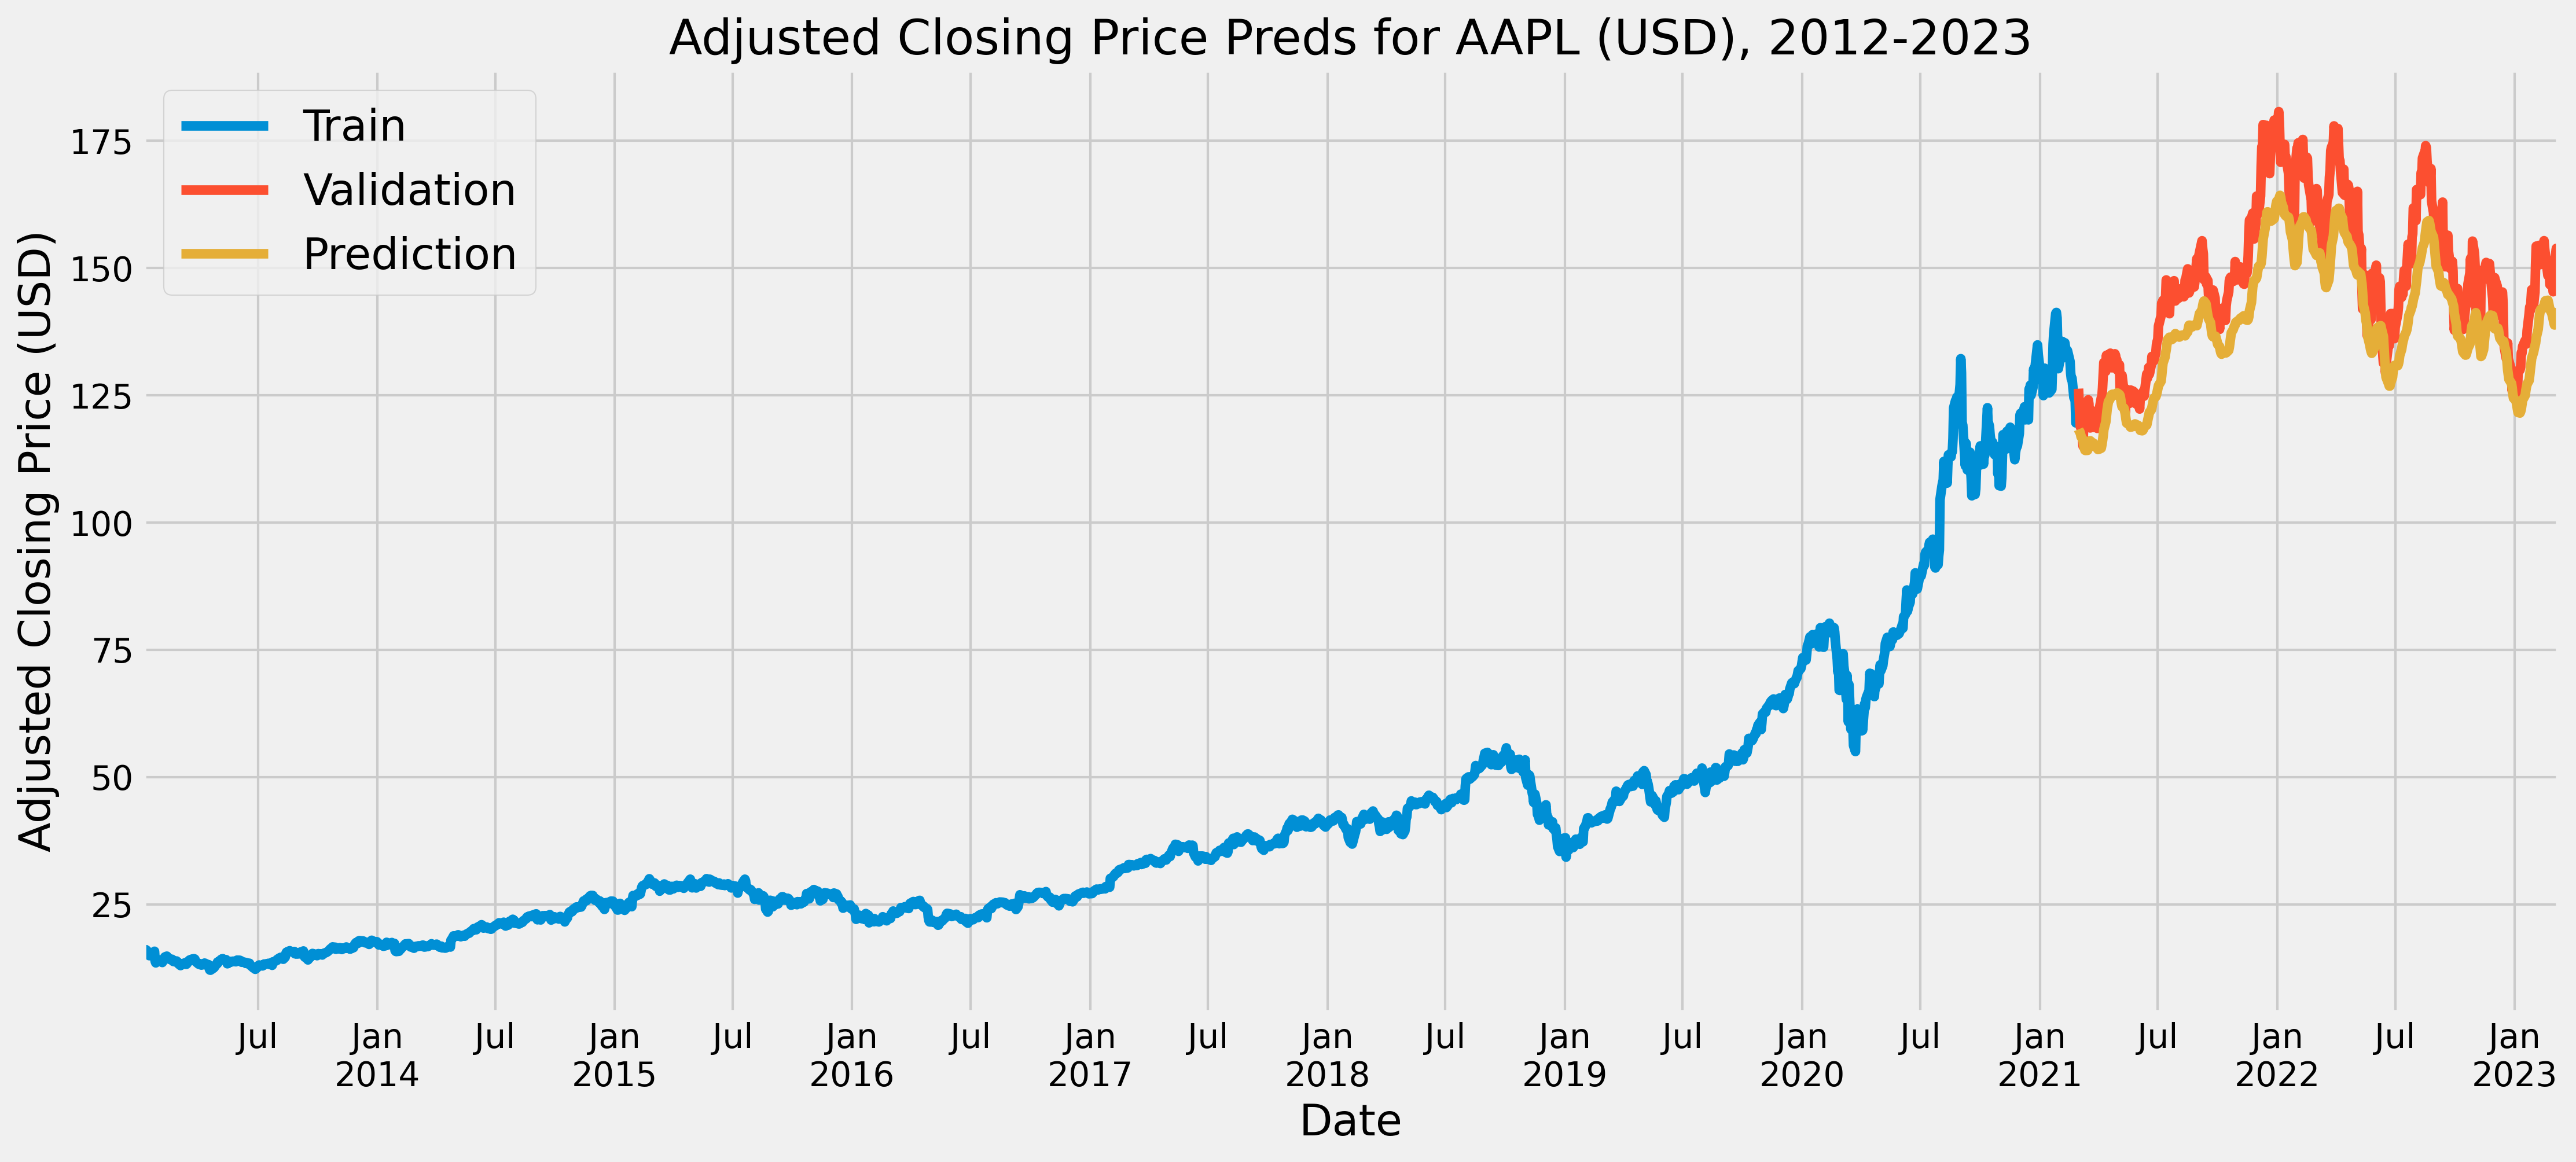

In [21]:
# plotting results.
data = datFull.filter(['AdjClose'])

train = data[:len_training]
valid = data[len_training:] # actual data that model predicted.
valid['Predictions'] = predictions


fig, ax = plt.subplots(1,1, dpi=300, figsize=(16,8),
    constrained_layout=False)

ax.plot(train.index, train.AdjClose, label='Train')
ax.plot(valid.index, valid.AdjClose, label='Validation')
ax.plot(valid.index, valid.Predictions, label='Prediction')


ax.set_title('Adjusted Closing Price Preds for %s (USD), %s-%s' 
             %(tickr, start.year, end.year))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Adjusted Closing Price (USD)', fontsize=18)
ax.legend(fontsize='18')

# Set major and minor date tick locators
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,6))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                      show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

ax.figure.autofmt_xdate(rotation=0, ha='center')
ax.set_xlim(datFull.index.min(), datFull.index.max());

### Multivariate LSTM Test 

See https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/

In [73]:
data

,AdjClose
Date,
2013-01-04,18.380356
2013-01-07,18.300158
2013-01-08,18.264042
2013-01-09,18.384092
2013-01-10,18.467777
...,...
2023-02-27,90.099998
2023-02-28,90.300003
2023-03-01,90.510002


In [74]:
# consolidating 'Close' prices to one stock.

# data = datFull.filter(['AdjClose', 'beta']).values
# len_training = math.ceil(len(data) * 0.8)

# # scaling data. Ensures quicker convergence to solution.
# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(data)

# # scaled training data.
# train_data = scaled_data[0:len_training,:]

# x_train = [] # features
# y_train = [] # desired prediction

# for i in range(60, len(train_data)):
#     x_train.append(train_data[i-60:i,0])
#     y_train.append(train_data[i,0])
    
# x_train, y_train = np.array(x_train), np.array(y_train)

# # reshaping to obtain 3D reps for x_train (which is currently 2d) to pass into LSTM.
# # LSTM expects d1 # of samples, d2 # of timesteps, and d3 # of features.

# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))




# # using 2 LSTM layers + Dense 25 neuron + Dense 1 neuron.
# model = Sequential()

# model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dense(25))
# model.add(Dense(1))

# model.compile(optimizer='adam', loss='mean_squared_error') # use categorical crossentropy for categories.




# model.fit(x_train, y_train, batch_size=1, epochs=1)



# # Creating test data w/ scaled values.
# test_data = scaled_close[len_training - 60:, :]

# x_test = []
# y_test = close[len_training:, :]
# for i in range(60, len(test_data)):
#     x_test.append(test_data[i-60:i, 0])
    
# x_test = np.array(x_test)

# # reshaping 2d x_test into 3d.
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))




# predictions = model.predict(x_test)
# predictions = scaler.inverse_transform(predictions)

# # computing error.
# rmse = np.sqrt(np.mean(predictions - y_test)**2)

# print("Model error: %.4f" %rmse)







---

In [1]:
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import datetime

import requests_cache

In [2]:
expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = 'DEFAULT_HEADERS'

# Tesla Group 

In [13]:
# scraping stock.
start = '2010-07-29'
end = datetime.datetime.today()
df = pdr.DataReader('TSLA', data_source='yahoo', start=start, end=end)

close = df.filter(['Close']).values
len_training = math.ceil(len(close) * 0.8)

# scaling data.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler.fit_transform(close)

# scaled training data.
train_close = scaled_close[0:len_training,:]

x_train = [] # features
y_train = [] # desired prediction

for i in range(60, len(train_close)):
    x_train.append(train_close[i-60:i,0])
    y_train.append(train_close[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# reshaping to obtain 3D reps for x_train (which is currently 2d) to pass into LSTM.
# LSTM expectt d1 # of samples, d2 # of timesteps, and d3 # of features.

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


# using 2 LSTM layers + Dense 25 neuron + Dense 1 neuron.
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


# compiling.
model.compile(optimizer='adam', loss='mean_squared_error')


# testing.
model.fit(x_train, y_train, batch_size=1, epochs=1)

test_data = scaled_close[len_training - 60:, :]

x_test = []
y_test = close[len_training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)

# reshaping 2d x_test into 3d.
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

ConnectionError: HTTPSConnectionPool(host='finance.yahoo.com', port=443): Max retries exceeded with url: /quote/TSLA/history?period1=1280394000&period2=1642327199&interval=1d&frequency=1d&filter=history (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x29717e3a0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

In [14]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

/var/folders/5l/9brv6cdn1b97f82knqyjcb4m0000gn/T/ipykernel_13015/389028320.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


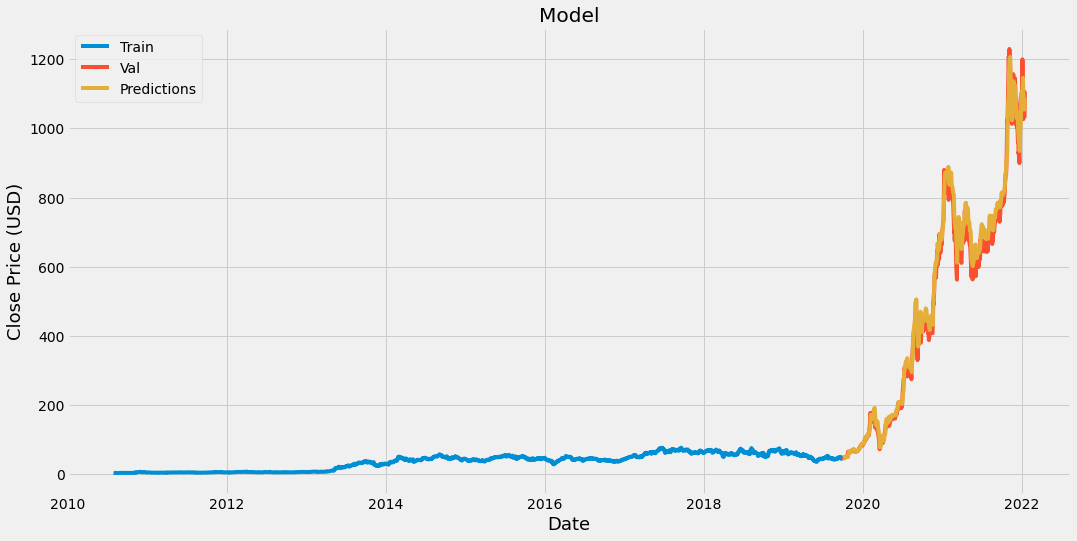

In [15]:
# plotting results.
data = df.filter(['Close'])

train = data[:len_training]
valid = data[len_training:] # actual data that model predicted.
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)

plt.legend(['Train', 'Val', 'Predictions'])

plt.show()

In [12]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

14.934396958640377